<a href="https://colab.research.google.com/github/yoseflio/Practical-ML-Course-HW/blob/main/tf_basic_regression_(auto_mpg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic regression: Predict fuel efficiency

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [ ]:
# Use seaborn for pairplot.
# !pip install -q seaborn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas:

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values:

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [7]:
dataset = dataset.dropna()

The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

Note: You can set up the `tf.keras.Model` to do this kind of transformation for you but that's beyond the scope of this tutorial. Check out the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) or [Load CSV data](../load_data/csv.ipynb) tutorials for examples.

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
train_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...,...
281,19.8,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,16.0,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,26.0,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0,1,0


### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

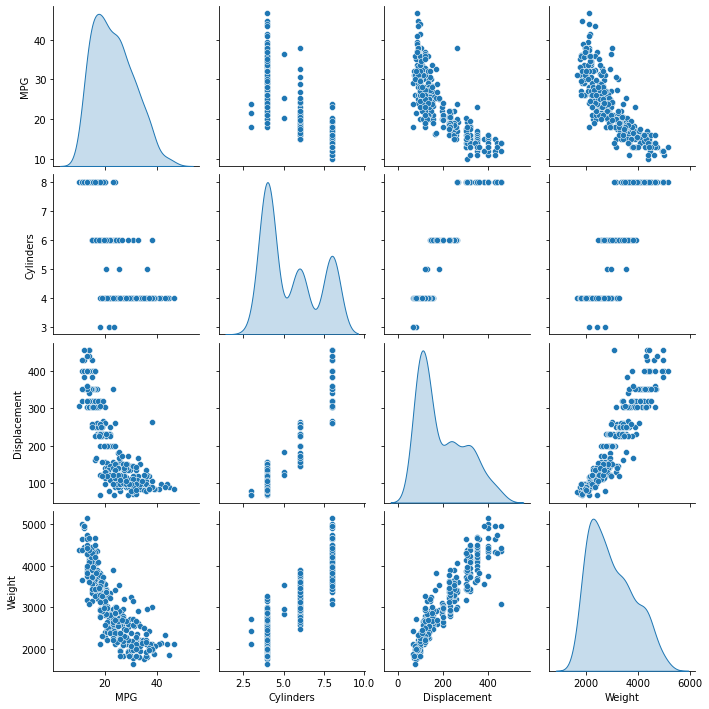

In [12]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [14]:
X_train = train_dataset.copy()
X_test = test_dataset.copy()

y_train = X_train.pop('MPG')
y_test = X_test.pop('MPG')

In [15]:
X_train

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [16]:
y_train

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

## Helper methods

In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 50])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [18]:
test_results = {}

## Linear regression

Before building a deep neural network model, start with linear regression.

This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [ ]:
train_dataset.shape

## Building sequential model

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

### Option 1

In [ ]:
linear_model = tf.keras.Sequential()

In [ ]:
linear_model

In [ ]:
X_train.shape

In [ ]:
linear_model.add(keras.Input(shape=(9,)))

In [ ]:
linear_model.summary()

In [ ]:
linear_model.add(layers.Dense(units=1, activation=None, use_bias=True))

In [ ]:
linear_model.summary()

### Option 2

In [ ]:
linear_model = tf.keras.Sequential([
    layers.Dense(units=1, activation=None)
])

In [ ]:
# cannot print summary until input shape is unknown
linear_model.summary()

In [ ]:
linear_model = tf.keras.Sequential([
    keras.Input(shape=(9,)),
    layers.Dense(units=1, activation=None)
])

In [ ]:
linear_model.summary()

### Option 3

You don't have to provide input layer, the model can understand it from the first call to predict/train

In [20]:
linear_model = tf.keras.Sequential([
    layers.Input(shape=(9,)),
    layers.Dense(units=1, activation=None)
])

In [22]:
linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [23]:
linear_model.compile(
    # optimizer=tf.optimizers.Adam(learning_rate=0.1),
    optimizer="Adam",
    loss='mean_absolute_error', # mean_squared_error
    #metrics=None,
    #weighted_metrics=None,
    #loss_weights=None
    )

https://keras.io/api/optimizers/


https://keras.io/api/losses/

### We can now examine the untrained model, and even predict

In [24]:
linear_model

In [25]:
linear_model.layers

In [26]:
linear_model.layers[0]

In [27]:
linear_model.layers[0].get_weights()

[array([[ 0.335],
        [-0.696],
        [-0.697],
        [-0.501],
        [ 0.526],
        [-0.041],
        [ 0.541],
        [ 0.621],
        [ 0.122]], dtype=float32), array([0.], dtype=float32)]

In [ ]:
len(linear_model.layers[0].get_weights())

In [ ]:
linear_model.layers[0].get_weights()[0]

In [ ]:
linear_model.layers[0].get_weights()[1]

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [28]:
linear_model.predict(X_train[:10])

array([[-1173.169],
       [-1598.907],
       [-2579.983],
       [-1175.468],
       [-1180.386],
       [-1823.957],
       [-1080.868],
       [-1765.988],
       [-1749.888],
       [-1261.327]], dtype=float32)

In [29]:
y_train[:10]

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
257    19.4
310    38.1
328    30.0
125    20.0
108    20.0
Name: MPG, dtype: float64

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

### Training the model

In [30]:
history = linear_model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    verbose=1, # logging
    validation_split=0.2 # Calculate validation results on 20% of the training data
    )

Epoch 1/100
8/8 [==============================] - 1s 29ms/step - loss: 1708.9471 - val_loss: 1705.3507
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 1681.7200 - val_loss: 1678.1753
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 1654.9015 - val_loss: 1650.8632
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 1627.6997 - val_loss: 1623.6678
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 1600.7224 - val_loss: 1596.4108
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 1573.7140 - val_loss: 1569.1566
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 1546.6769 - val_loss: 1541.9142
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 1519.6566 - val_loss: 1514.6671
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 1492.4016 - val_loss: 1487.5420
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - l

In [31]:
history.history

{'loss': [1708.9471435546875,
  1681.719970703125,
  1654.9014892578125,
  1627.69970703125,
  1600.722412109375,
  1573.7139892578125,
  1546.6768798828125,
  1519.6566162109375,
  1492.401611328125,
  1465.4615478515625,
  1438.4481201171875,
  1411.361572265625,
  1384.323486328125,
  1357.2947998046875,
  1330.285400390625,
  1303.260498046875,
  1276.1739501953125,
  1249.185546875,
  1222.052734375,
  1195.2852783203125,
  1167.953857421875,
  1140.9503173828125,
  1114.062744140625,
  1087.0782470703125,
  1059.91357421875,
  1032.926025390625,
  1006.0658569335938,
  978.7433471679688,
  951.843505859375,
  924.8939819335938,
  897.7987670898438,
  870.8126220703125,
  843.5719604492188,
  816.7635498046875,
  789.4586791992188,
  762.6209716796875,
  735.650146484375,
  708.5391845703125,
  681.4696044921875,
  654.2318115234375,
  627.4512329101562,
  600.3369140625,
  573.357666015625,
  546.2547607421875,
  519.297119140625,
  492.2216796875,
  464.9476318359375,
  438.0422

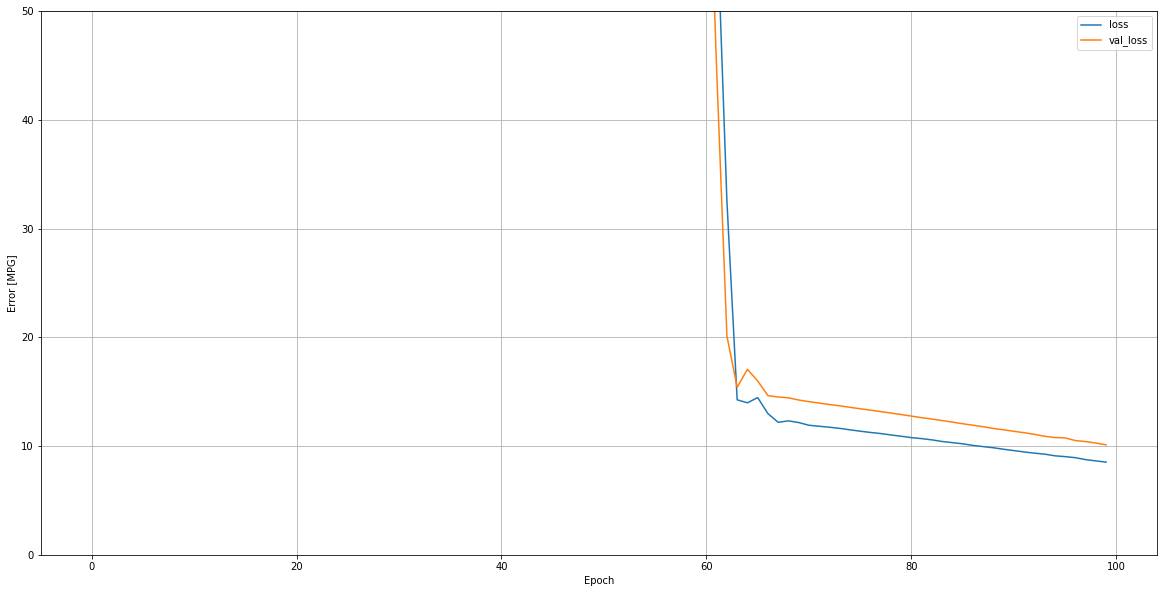

In [32]:
plot_loss(history)

## Adding Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [33]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [34]:
normalizer.adapt(np.array(X_train))

Calculate the mean and variance:

In [35]:
print(normalizer.mean, normalizer.variance, normalizer.count)

tf.Tensor(
[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]], shape=(1, 9), dtype=float32) tf.Tensor(
[[     2.88   10850.413   1446.699 709896.9        7.755     13.467
       0.147      0.158      0.235]], shape=(1, 9), dtype=float32) <tf.Variable 'count:0' shape=() dtype=int64, numpy=314>


When the layer is called, it returns the input data, with each feature independently normalized:

In [ ]:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

Create the model with normalization layer

In [36]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1, activation=None)
])

In [37]:
linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


Compile the model

In [38]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics=None,
    weighted_metrics=None,
    loss_weights=None)

Train the model

In [39]:
history = linear_model.fit(
    x=X_train,
    y=y_train,
    batch_size=None,
    epochs=100,
    verbose=1, # logging
    validation_split = 0.2 # Calculate validation results on 20% of the training data
    )

Epoch 1/100
8/8 [==============================] - 0s 20ms/step - loss: 22.9356 - val_loss: 22.8764
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 22.0952 - val_loss: 22.1702
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 21.2592 - val_loss: 21.4145
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 20.4495 - val_loss: 20.7238
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 19.6176 - val_loss: 20.0123
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 18.7916 - val_loss: 19.2805
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 18.0057 - val_loss: 18.5748
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 17.1713 - val_loss: 17.8730
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 16.3562 - val_loss: 17.1107
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 15.5558 - val_loss: 16.3920
Epoch 11

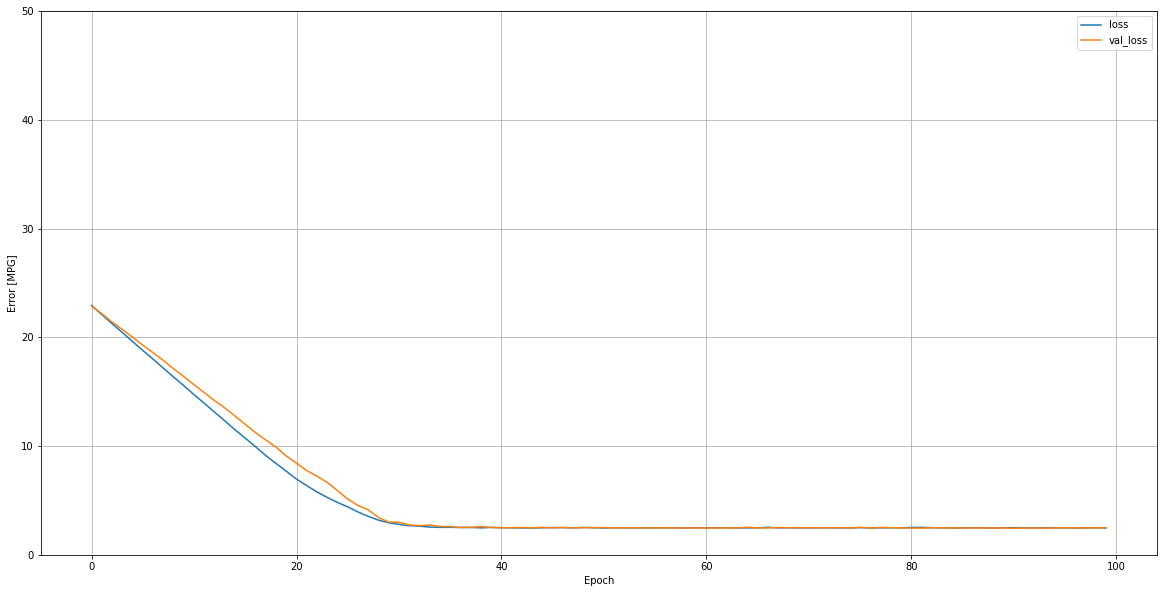

In [40]:
plot_loss(history)

Evaluate the model

In [41]:
linear_model.evaluate(X_test, y_test, verbose=0)

2.4513776302337646

Collect the results on the test set for later:

In [42]:
test_results['linear_model'] = linear_model.evaluate(
    X_test, y_test, verbose=0)

In [43]:
test_results

{'linear_model': 2.4513776302337646}

## Regression with a deep neural network (DNN)

In the previous section, we implemented linear model.

Now we will implement DNN model.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

In [44]:
dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation=None)])

dnn_model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
dnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                640       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,772
Trainable params: 2,753
Non-trainable params: 19
_________________________________________________________________


In [51]:
history = dnn_model.fit(
    X_train,
    y_train,
    # batch_size=len(train_labels),
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 12ms/step - loss: 1.3313 - val_loss: 2.2156
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 1.3241 - val_loss: 2.1775
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 1.3133 - val_loss: 2.2034
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 1.3179 - val_loss: 2.1539
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 1.2849 - val_loss: 2.1959
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 1.2843 - val_loss: 2.1855
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 1.2994 - val_loss: 2.1508
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 1.2972 - val_loss: 2.1935
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 1.3075 - val_loss: 2.2077
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 1.3349 - val_loss: 2.1976
Epoch 11/100
8/8 [==========

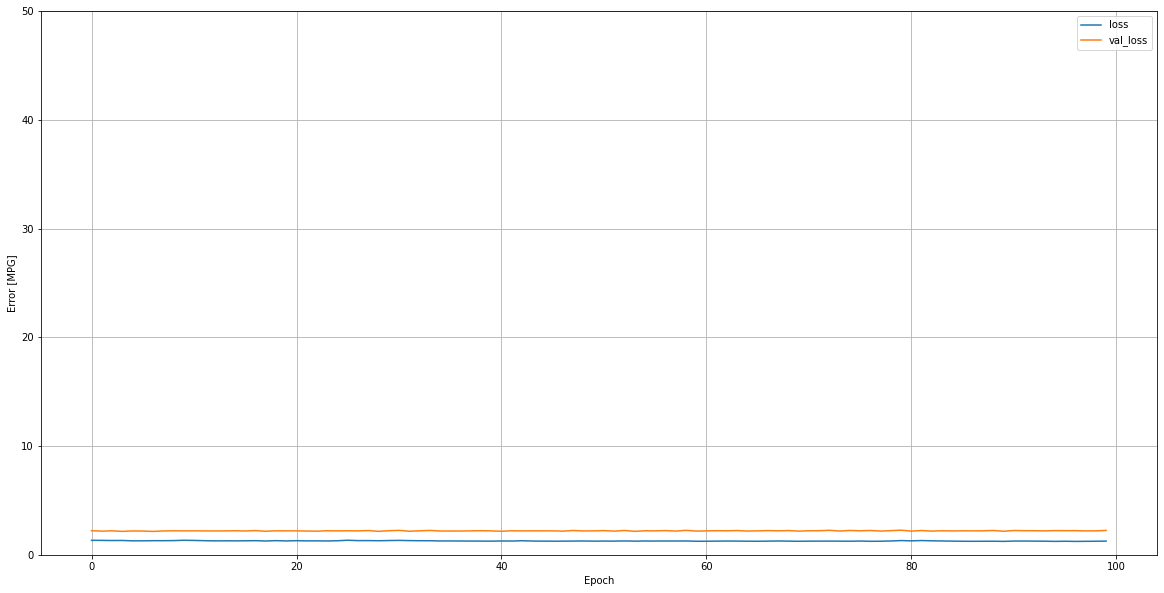

In [52]:
plot_loss(history)

Collect the results on the test set:

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)
# dnn_model.evaluate(X_test, y_test)

In [54]:
test_results

{'dnn_model': 1.9334204196929932, 'linear_model': 2.4513776302337646}

## Performance

Since all models have been trained, you can review their test set performance:

In [55]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.451378
dnn_model,1.933420


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

In [56]:
test_predictions = dnn_model.predict(X_test)
print(test_predictions[:10])

[[14.565]
 [11.161]
 [12.189]
 [24.982]
 [20.534]
 [13.203]
 [13.971]
 [12.967]
 [19.485]
 [30.55 ]]


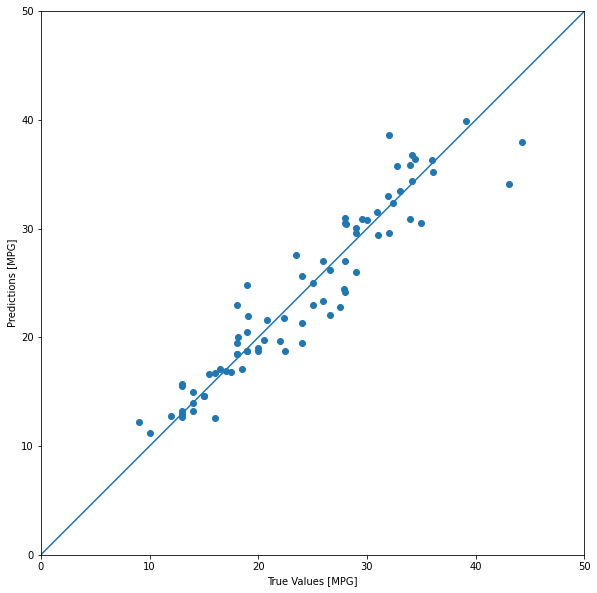

In [57]:
test_predictions = dnn_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

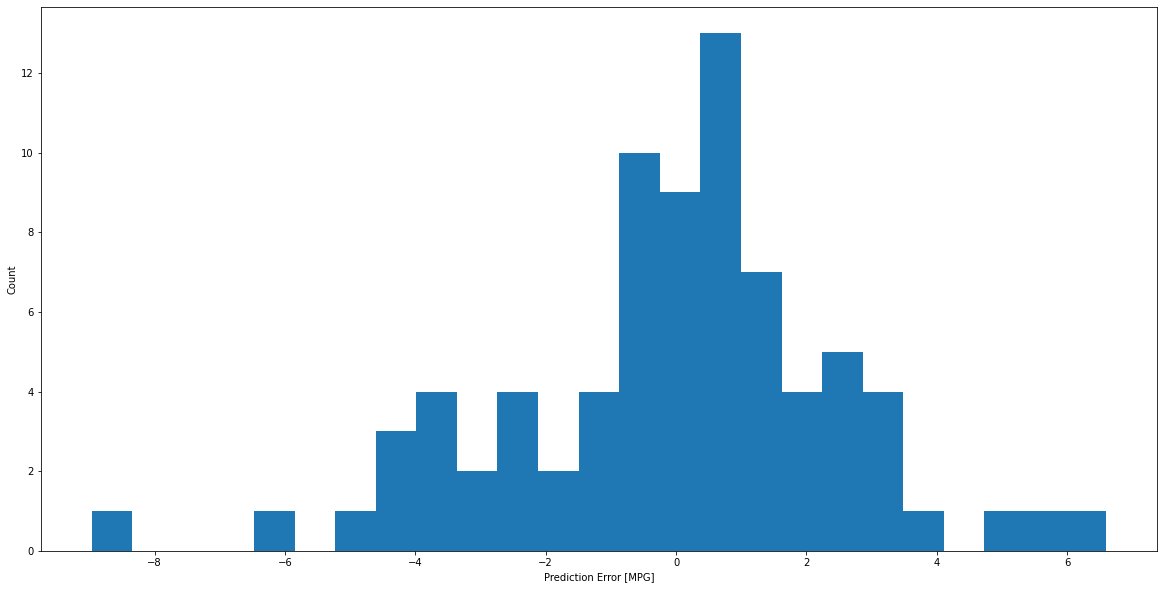

In [58]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [59]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


If you reload the model, it gives identical output:

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    X_test, y_test, verbose=0)

In [ ]:
reloaded.evaluate(X_test, y_test, verbose=0)

### You can continue training the reloaded model as well

In [ ]:
history = reloaded.fit(X_train,
    y_train,
    # batch_size=len(train_labels),
    validation_split=0.2,
    verbose=1, epochs=10)

In [ ]:
plot_loss(history)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T